In [1]:
import numpy as np
from copy import deepcopy
import pandas as pd
import time

In [2]:
def product(a,b):
    '''
    this returns the product of
    b * (b-1) * (b-2) * ... * (b-a+1)
    '''
    
    if a == 0:
        return 1
    if b < a:
        return 0
    return np.product(np.arange(b-a+1,b+1,1))

## Gillespie for a simple chemical process


this file is the code for the **Gillespie algorithm** applied to a very simple chemical process. 

There are two populations
- $x_1$: the number of $O_2$ molucules
- $x_2$: the number of $O$ molucules. 

And there are two chemical reactions:
- **binding**: $O+O \to O_2$, with reaction rate $k_+(x_2)(x_2-1)$
- **breaking**: $O_2 \to O+O$, with reaction rate $k_-x_1$



## model


In [3]:
# compounds should be a dictionary, key = name of the conpund, val = quantity of the counpound. 

class reaction:
    
    def __init__(self,input_compounds, output_compounds, reaction_rate, name=None):
        
        self.input = input_compounds
        self.output = output_compounds
        self.rr = reaction_rate
        self.name = name
    
    def proba(self,i):
        
        return self.rr * np.product([product(self.input[key],i[key]) for key in self.input])
    
class chemical_system:
    
    def __init__(self, chemicals, reactions):
        
        self.chemicals = deepcopy(chemicals)
        self.reactions = reactions
    
    def gillespie(self,t,T):
        
        # calculate probability
        A = [reaction.proba(self.chemicals) for reaction in self.reactions]
        a = sum(A)
                
        # sampling next time
        dt = np.random.exponential(1/sum(A))
        
        if t + dt > T:
            return None
        
        # sampling next action
        A = A/a
        action = np.random.choice(self.reactions,1,False,A)[0]
        
        # take the action. 
        for c in self.chemicals:
            self.chemicals[c] -= action.input[c]
            self.chemicals[c] += action.output[c]
            if self.chemicals[c] < 0:
                assert(False)
        
        return t + dt
        
    def simulation(self, T, record=False):
            
        t = 0
        
        if record:
            records = [[t] + list(self.chemicals.values())]
        
        while t != None:
            t = self.gillespie(t,T)
            if record and t != None:
                records.append([t] + list(self.chemicals.values()))

        if record:
            records = pd.DataFrame(data=records,columns=['time']+ list(self.chemicals.keys()))
            return records.set_index('time')
           

## Initialization

In [4]:
chemicals = {
    "O_2": 5000,
    "O":   4000
    }

binding = reaction(
    input_compounds  = {'O':2, 'O_2':0},
    output_compounds = {'O':0, 'O_2':1},
    reaction_rate    = .0004
)

breaking = reaction(
    input_compounds={'O':0, 'O_2':1},
    output_compounds={'O':2, 'O_2':0},
    reaction_rate = .2
)

reactions = [binding, breaking]


def init_chemical_system():
    return chemical_system(chemicals,reactions)

In [5]:
chem_sys = init_chemical_system()
s = time.time()
records = chem_sys.simulation(T=20, record=True)
e = time.time()
e-s

1.8963446617126465

In [6]:
pd.Series(records.index).diff().dropna().mean()

0.00040190836938054045

scientific notation

In [11]:
len(records)

49763

<AxesSubplot:xlabel='time'>

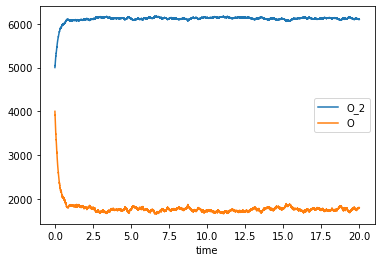

In [7]:
records.plot()

In [8]:
arr = records.to_numpy()
ratio = arr[:,0]/arr[:,1]

In [9]:
from matplotlib import pyplot as plt

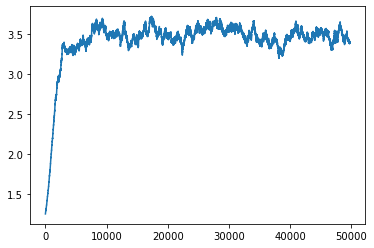

In [10]:
plt.plot(ratio)